In [2]:
import sys
sys.path.append('../')
from src.my_classes import my_classes_l1, colors_classes_l1

In [3]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors

In [4]:
l1_int = pd.read_csv("../csv/l1_int.csv")
#l2_int = pd.read_csv("../csv/l2_int.csv")

In [4]:
# add column to l1_int called name which corresponds to the value from my_classes_1 when the id is matched
l1_int['name'] = l1_int['class'].map(my_classes_l1)
# add a column color to l1_int which corresponds to the value from colors_classes_1 when the id is matched
l1_int['color'] = l1_int['class'].map(colors_classes_l1)
# turn nan to Other in the name column
l1_int['name'] = l1_int['name'].fillna('Other')
print(l1_int.head(7))

  class  int                                               name    color
0     E    1  Prairies, terrains domines par des especes non...  #789262
1     F    2                        Landes, fourres et toundras  #ff4500
2     G    3             Bois, forets et autres habitats boises  #006400
3     I    4  Habitats agricoles, horticoles et domestiques ...  #00ff00
4     J    5  Zones baties, sites industriels et autres habi...  #555555
5     Z    6                                              Other      NaN


In [5]:
my_colors_map = l1_int.set_index('int')['color'].to_dict()
my_colors_map[6] = '#8a2be2'
print(my_colors_map)

{1: '#789262', 2: '#ff4500', 3: '#006400', 4: '#00ff00', 5: '#555555', 6: '#8a2be2'}


In [5]:
# img name img_zone1_0_0_patch_1_12.tif
# msk name msk_zone1_0_0_patch_1_12.tif

class EcomedDataset(Dataset):
    def __init__(self, msk_paths, img_dir, level=1):
        self.img_dir = img_dir
        self.level = level
        self.msks = msk_paths
        self.imgs = [self.img_dir / msk_path.parts[-2] / msk_path.name.replace('msk', 'img').replace('l123/', '') for msk_path in self.msks]
                
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]
        with rasterio.open(msk_path) as src:
            msk = src.read(self.level)
        with rasterio.open(img_path) as src:
            img = src.read()
        img = img.astype(np.int16)
        return img, msk

In [7]:
def plot_img_msk(img_list, msk_list, my_colors_map):
    num_images = len(img_list)
    fig, axes = plt.subplots(num_images, 2, figsize=(5,20))
    for i in range(0, num_images):
        img = img_list[i]
        msk = msk_list[i]
        classes = np.unique(msk)
        legend_colors = [my_colors_map[c] for c in classes]
        custom_cmap = mcolors.ListedColormap(legend_colors)
        img = img[:3]  # Supprimer le canal IR
        p2, p98 = np.percentile(img, (2, 98), axis=(1, 2))
        img = np.clip((img - p2[:, None, None]) / (p98[:, None, None] - p2[:, None, None]), 0, 1)
        
        axes[i, 0].imshow(img.permute(1, 2, 0))
        im = axes[i, 1].imshow(msk, cmap=custom_cmap)        
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')    
    plt.tight_layout()
    plt.show()

In [11]:
settings_dict = {
    'patch_size': 256, 
    'level': 1, 
    'bs': 32,#32 
    'shuffle': 'random', 
}
img_folder = Path(f'../data/patch{settings_dict["patch_size"]}/img/')
msks_256_fully_labelled = pd.read_csv('../csv/coverage_patch/l1_256_100per_labelled.csv')
msk_paths = list(msks_256_fully_labelled['mask_path'])
msk_paths = [Path(p) for p in msk_paths]
for msk_path in msk_paths:
    if not msk_path.exists():
        msk_paths.remove(msk_path)

In [9]:
# Create a dataloader for level 1
dataset = EcomedDataset(msk_paths, img_folder, settings_dict['level'])
dataloader = DataLoader(dataset, batch_size=settings_dict['bs'], shuffle=True)

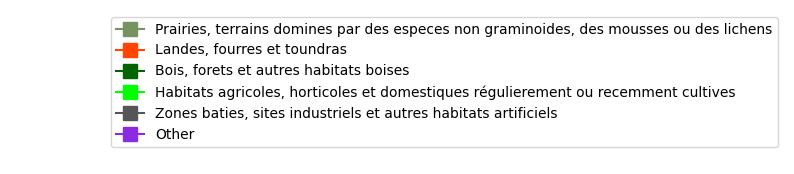

In [69]:
plt.figure(figsize=(10, 2))
color_square_size = 10
# Plot color squares for each class in the legend
for c in range(1, len(my_colors_map)+1):
    plt.plot([], [], color=my_colors_map[c], marker='s', markersize=color_square_size,
                label=l1_int[l1_int['int'] == c]['name'].values[0])
plt.legend()
plt.axis('off')
plt.box(False)
plt.show()

/home/bertille/miniconda3/envs/ecomed_venv/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Image 0 has classes [3 5]
Image 0 has classes [5]
Image 0 has classes [5]
Image 0 has classes [5]
Image 0 has classes [2 3 5]
Image 0 has classes [3 5]
Image 0 has classes [1 3 5]


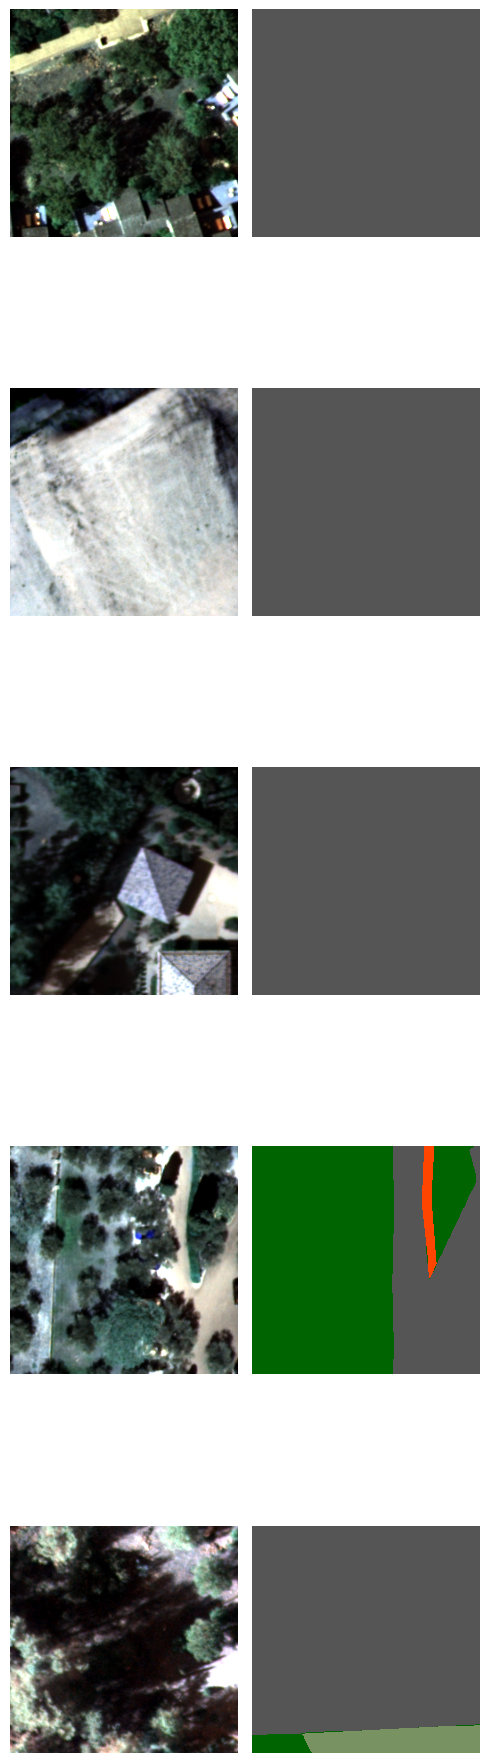

In [68]:
#plot images with classs 5
img_list = []
msk_list = []
for i, (img, msk) in enumerate(dataloader):
    for j in range(img.shape[0]):
        if 5 in msk[j]:
            count = np.count_nonzero(msk[j] == 5)
            print(f"Image {i} has classes {np.unique(msk[j])}")
            if count > 0.2 * (256*256):
                img_list.append(img[j])
                msk_list.append(msk[j])
                if len(img_list) == 5:
                    break
    if len(img_list) == 5:
        break

plot_img_msk(img_list, msk_list, my_colors_map)

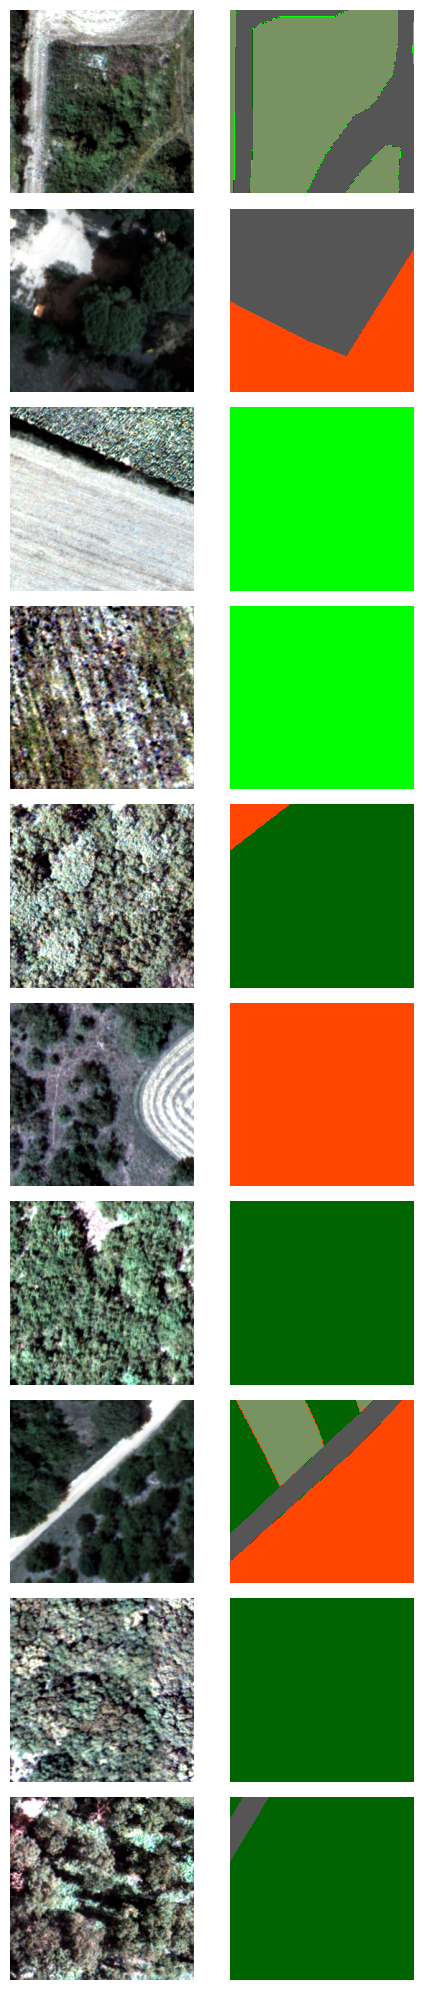

In [71]:
# plot 50 images and masks
for i, (img, msk) in enumerate(dataloader):
    plot_img_msk(img[:10], msk[:10], my_colors_map)
    break

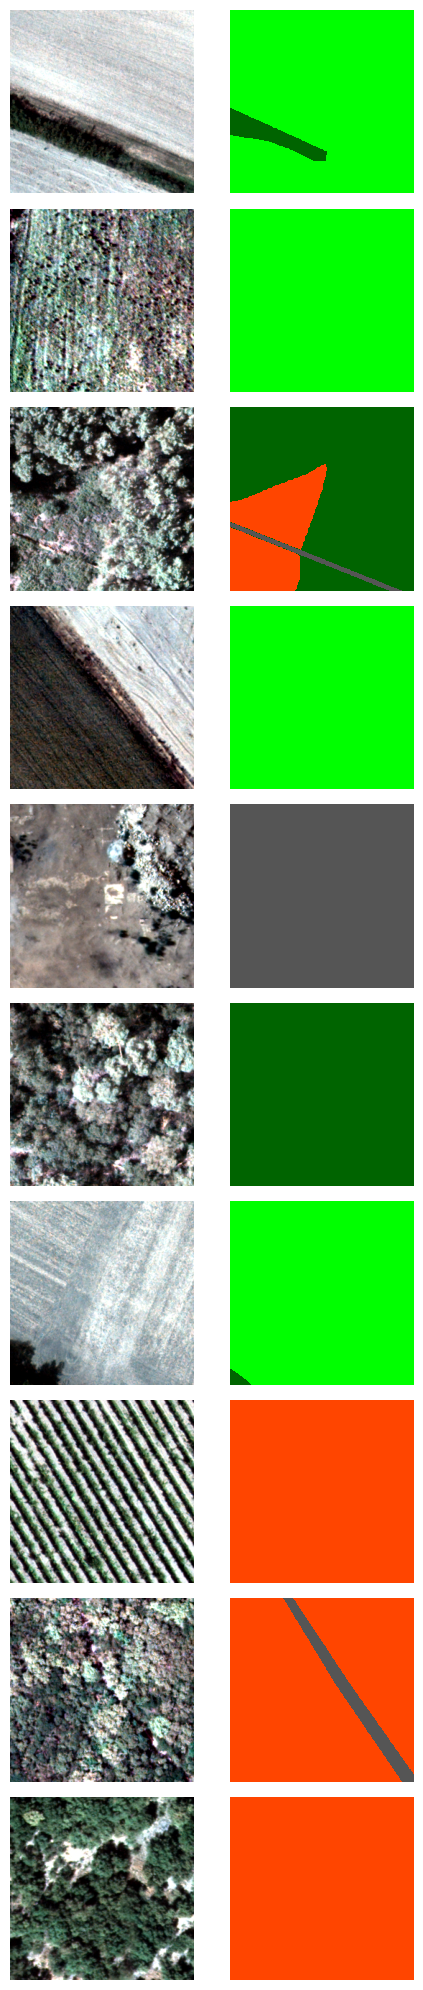

In [72]:
# plot 50 images and masks
for i, (img, msk) in enumerate(dataloader):
    plot_img_msk(img[10:20], msk[10:20], my_colors_map)
    break

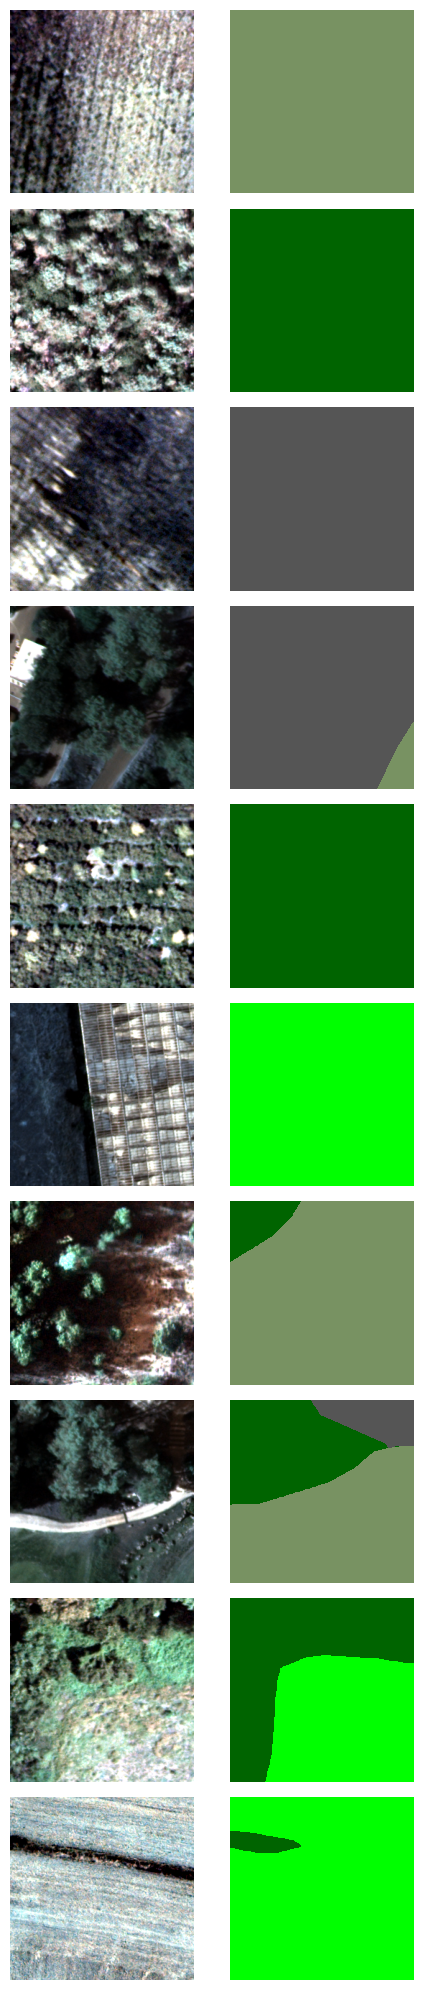

In [73]:
# plot 50 images and masks
for i, (img, msk) in enumerate(dataloader):
    plot_img_msk(img[20:30], msk[20:30], my_colors_map)
    break

In [14]:
# Sanity check of masj_paths existence
print(f"Total masks: {len(msk_paths)}")
i = 0
for msk_path in msk_paths:
    if not msk_path.exists():
        i += 1
        print(f"Missing {msk_path}")
        #remove it from the list
        msk_paths.remove(msk_path)
print(f"Total masks missing: {i}")
print(f"Total masks: {len(msk_paths)}") # zone 5 had invalid dates
# Sanity check of img_paths existence
j = 0
img_paths = [img_folder / msk_path.parts[-2] / msk_path.name.replace('msk', 'img').replace('l123/', '') for msk_path in msk_paths]
for img_path in img_paths:
    if not img_path.exists():
        j += 1
        print(f"Missing {img_path}")

print(f"Total images missing: {j}")
print(f"Total images: {len(img_paths)}")

Total masks: 9467
Missing ../data/patch256/msk/l123/zone5_0_0/msk_zone5_0_0_patch_12_24.tif
Missing ../data/patch256/msk/l123/zone5_0_0/msk_zone5_0_0_patch_13_22.tif
Missing ../data/patch256/msk/l123/zone5_0_0/msk_zone5_0_0_patch_13_24.tif
Missing ../data/patch256/msk/l123/zone5_0_0/msk_zone5_0_0_patch_14_24.tif
Missing ../data/patch256/msk/l123/zone5_0_0/msk_zone5_0_0_patch_15_24.tif
Missing ../data/patch256/msk/l123/zone5_0_1/msk_zone5_0_1_patch_11_1.tif
Missing ../data/patch256/msk/l123/zone5_0_1/msk_zone5_0_1_patch_12_2.tif
Missing ../data/patch256/msk/l123/zone5_0_1/msk_zone5_0_1_patch_12_4.tif
Missing ../data/patch256/msk/l123/zone5_0_1/msk_zone5_0_1_patch_13_2.tif
Missing ../data/patch256/msk/l123/zone5_0_1/msk_zone5_0_1_patch_13_4.tif
Missing ../data/patch256/msk/l123/zone5_1_0/msk_zone5_1_0_patch_2_20.tif
Missing ../data/patch256/msk/l123/zone16_0_0/msk_zone16_0_0_patch_4_5.tif
Missing ../data/patch256/msk/l123/zone16_0_0/msk_zone16_0_0_patch_5_4.tif
Missing ../data/patch256/m

In [15]:
#check in remaining images fro mimg_paths if there images with only 0 values
for msk_path in msk_paths:
    if not msk_path.exists():
        msk_paths.remove(msk_path)

img_paths = [img_folder / msk_path.parts[-2] / msk_path.name.replace('msk', 'img').replace('l123/', '') for msk_path in msk_paths]

mis = 0
zero = 0
imgs_zero_paths = []
for img_path in img_paths:
    if not img_path.exists():
        print(f"Missing {img_path}")
        mis += 1
    else: 
        with rasterio.open(img_path) as src:
            img = src.read()
        if np.count_nonzero(img) == 0:
            zero += 1
            imgs_zero_paths.append(img_path)

print(f"Total images missing: {mis}")
print(f"Total images with zero values: {zero}")
print(f"Total images: {len(img_paths)}")

msk_folder = Path(f'../data/patch{settings_dict["patch_size"]}/msk/l123')
# transform the images with zero values path to msks_paths_zero
msks_paths_zero = [msk_folder / img_path.parts[-2] / img_path.name.replace('img', 'msk') for img_path in imgs_zero_paths]
print(msks_paths_zero)
print(len(msk_paths))
#remove msks_paths_zero from msk_paths
for msk_path in msks_paths_zero:
    if msk_path in msk_paths:
        msk_paths.remove(msk_path)

print(len(msk_paths))

/home/bertille/miniconda3/envs/ecomed_venv/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_10_5.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_10_6.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_11_11.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_11_5.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_11_6.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_11_7.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_11_8.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_12_10.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_12_11.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_12_12.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_12_6.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_12_7.tif
Zero values ../data/patch256/img/zone74_0_1/img_zone74_0_1_patch_12_8.tif
Zero values ../data/patch256/img/z

In [16]:
print(len(msk_paths))
#remove msks_paths_zero from msk_paths
for msk_path in msks_paths_zero:
    if msk_path in msk_paths:
        msk_paths.remove(msk_path)

print(len(msk_paths))

9434
9247


In [17]:
# print unique values in Missing ../data/patch256/msk/l123/zone16_0_0/msk_zone16_0_0_patch_4_6.tif
#with rasterio.open('../data/patch256/msk/l123/zone16_0_0/msk_zone16_0_0_patch_4_6.tif') as src:
#    msk = src.read(1)
#    print(np.unique(msk))